# Robustness of model (missed one train season)
We will evaluate the performance of the proposed AdaBoost model over 14 test seasons from 2014NH to 2020SH, where data of one season is excluded from model training.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "GIAG010101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',   # virus passage category
                 'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

missed_train_Seasons = ['2013SH', '2014NH', '2014SH', '2015NH', '2015SH',  '2016NH', '2016SH',
                        '2017NH', '2017SH', '2018NH', '2018SH', '2019NH', '2019SH', '2020NH']   # missed train seasons

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig4_robustness/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
results_fn = path_result + "SuppFig4c_robustness_miss1TrainSeason.csv"   # to save performance scores for test dataset

# filenames for figures are mentioned within the codes for figures

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and validation datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and validate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern of Southern Hemisphere season such as "2015NH"

> **Returns**
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season

In [5]:
def train_test_season(season, missed_train_season):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.miss1TrainSeason_seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']],
                                                                               test_season=season,
                                                                               missed_season=missed_train_season)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    '''
    Target (NHTs)
    '''
    y_train = data_train.nht.values
    y_test  = data_test.nht.values


    del X_train_meta, X_test_meta, data_train, data_test
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    y_train,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'missed_train_season', 'season']
    col_values = [mut_mat, model_name, metadata, missed_train_season, season]
    utilities.compute_scores(y_test, results['pred_test'], results_fn, col=cols, col_val=col_values)

## Performance of the model
- For each missed season from training dataset
    - For each test season from 2014NH to 2020SH
        - Split the data into training and test datasets
        - Prepare encoded inputs (genetic difference and metadata features)
        - Train and evaluate the model
        - Compute predictive performance
        - Save the predictions
    - Compute average predictive performance

In [6]:
'''
Missed train season
'''
# we need index to start Test_Seasons after current missed_train_season
for ind, missed_train_season in enumerate(missed_train_Seasons):
    print("Missed train season: ", missed_train_season)
    
    # train test for each test season in parallel
    Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season, missed_train_season) for test_season in Test_Seasons[ind:])


    ####################################
    # loop over missed_train_Seasons end
    ####################################

Missed train season:  2013SH


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-09 22:39:47.606190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 22:39:47.977957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 22:39:48.515843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 205.48908972740173
Time for training: 345.07883071899414
Time for training: 559.6335968971252
Time for training: 757.8619465827942
Time for training: 905.5382707118988
Time for training: 989.2028255462646
Time for training: 1134.222409248352
Time for training: 1507.878357887268
Time for training: 1647.625947713852
Time for training: 1801.242155790329
Time for training: 1946.6373805999756


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 39.5min remaining:  6.6min


Time for training: 2260.728979110718
Time for training: 2761.0326590538025
Missed train season:  2014NH


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 55.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-09 23:34:55.119103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 23:34:55.119102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 23:34:55.242008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 290.0489733219147
Time for training: 508.90036273002625
Time for training: 714.2821884155273
Time for training: 844.8569538593292
Time for training: 939.8784646987915
Time for training: 1080.305159330368


[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed: 27.2min remaining: 17.0min


Time for training: 3169.663886785507
Time for training: 1426.566712141037
Time for training: 1552.7998394966125
Time for training: 1699.9980902671814
Time for training: 1854.3163135051727
Time for training: 2167.006336450577
Time for training: 2608.0331149101257


[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed: 52.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Missed train season:  2014SH


2023-10-10 00:27:36.264635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:27:36.468727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:27:37.111477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 3029.770899295807
Time for training: 484.91934275627136


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed: 16.4min remaining: 32.8min


Time for training: 702.5247237682343
Time for training: 837.9080111980438
Time for training: 934.1369268894196
Time for training: 1070.5611431598663
Time for training: 1394.556584596634
Time for training: 1587.7741100788116
Time for training: 1683.7769820690155
Time for training: 1831.8718190193176
Time for training: 2132.620496034622
Time for training: 2533.828237771988
Missed train season:  2015NH


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 51.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 01:19:07.044353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 01:19:07.534627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 01:19:08.027128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2963.0634047985077
Time for training: 699.6081504821777
Time for training: 899.3125379085541
Time for training: 1012.1528162956238
Time for training: 1136.3104147911072
Time for training: 1447.965582370758
Time for training: 1628.595985174179
Time for training: 1764.4986448287964
Time for training: 1881.9359312057495
Time for training: 2179.587411403656
Time for training: 2681.1502776145935
Missed train season:  2015SH


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed: 53.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 02:12:28.502700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 02:12:29.033964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 02:12:29.393103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3071.4059882164
Time for training: 982.8442752361298
Time for training: 1093.673411846161
Time for training: 1216.345020532608
Time for training: 1595.505220413208


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 35.6min remaining: 15.3min


Time for training: 1770.8187494277954
Time for training: 1889.9407675266266
Time for training: 2043.21151638031
Time for training: 2448.852782011032
Time for training: 2869.4791843891144
Missed train season:  2016NH


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 58.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 03:10:49.323921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 03:10:49.578291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 03:10:50.262344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3365.9734332561493
Time for training: 1133.874024629593
Time for training: 1269.3085203170776
Time for training: 1703.4787526130676
Time for training: 1862.1482927799225
Time for training: 1961.82386636734
Time for training: 2147.1499695777893
Time for training: 2449.381417274475
Time for training: 2967.023200750351
Missed train season:  2016SH


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 60.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 04:11:11.361458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 04:11:11.727458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 04:11:12.160588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3482.983123779297
Time for training: 1252.5502560138702
Time for training: 1662.861858844757
Time for training: 1789.6053314208984
Time for training: 1929.9982793331146
Time for training: 2078.284133911133


[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 42.0min remaining: 14.0min


Time for training: 2413.075541496277
Time for training: 2878.5814774036407
Missed train season:  2017NH


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 58.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 05:09:43.330908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 05:09:43.643247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 05:09:44.105664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3374.7541530132294
Time for training: 1413.0374014377594
Time for training: 1561.8391001224518
Time for training: 1665.3169639110565
Time for training: 1829.1730341911316
Time for training: 2151.667357444763
Time for training: 2608.606210231781
Missed train season:  2017SH


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 52.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 06:01:48.630432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 06:01:49.236510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 06:01:49.504985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3000.45405125618
Time for training: 1773.9796495437622
Time for training: 1936.7515263557434
Time for training: 2107.158319234848
Time for training: 2423.255598306656
Time for training: 2910.9215886592865
Missed train season:  2018NH


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 58.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 06:59:53.495435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 06:59:53.949447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 06:59:54.386887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3348.845320701599
Time for training: 2005.2920541763306
Time for training: 2171.7842876911163
Time for training: 2515.191004514694
Time for training: 2997.2046995162964
Missed train season:  2018SH


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 60.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 07:59:53.917237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 07:59:54.440702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 07:59:54.951936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 3463.249019384384
Time for training: 2111.7162714004517


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 43.1min remaining: 43.1min


Time for training: 2477.0301110744476
Time for training: 2969.5326087474823
Missed train season:  2019NH


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 60.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 09:00:01.186059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 09:00:01.736949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 3472.894743680954
Time for training: 2301.459216117859
Time for training: 2783.7041273117065
Missed train season:  2019SH


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 56.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-10 09:56:29.008522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 3262.0057232379913
Time for training: 2701.2663567066193
Missed train season:  2020NH


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 54.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 54.5min finished


Time for training: 3137.2753252983093
Time for training: 3147.4297239780426


## Imports and configuration for plotting

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline


sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores and prepare data for plots

In [12]:
# read reference scores, without any missing seasons from training dataset
scores_reference = pd.read_csv("../results/Fig2_model_evaluation/Fig2_performance_testScores.csv")
scores_reference = scores_reference[scores_reference.season != 'Average']
scores_reference['missed_train_season'] = 'Reference'
scores_reference = scores_reference[["missed_train_season", "season", "MAE"]]

# read results of this simulation
scores = pd.read_csv(results_fn)
scores = scores[["missed_train_season", "season", "MAE"]]

# combine scores
scores = pd.concat([scores_reference, scores], ignore_index=True)

'''
for heatmap change to matrix form
'''
df = scores.pivot(index='missed_train_season', columns='season', values='MAE')

mask = np.ones_like(df[df.index!="Reference"])
mask[np.triu_indices_from(mask)] = False

# difference of MAE values w.r.t Reference
diff_df = df - df[df.index=="Reference"].to_numpy()

## Plot heatmap of difference of MAE values w.r.t reference vs. test seasons

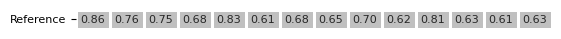

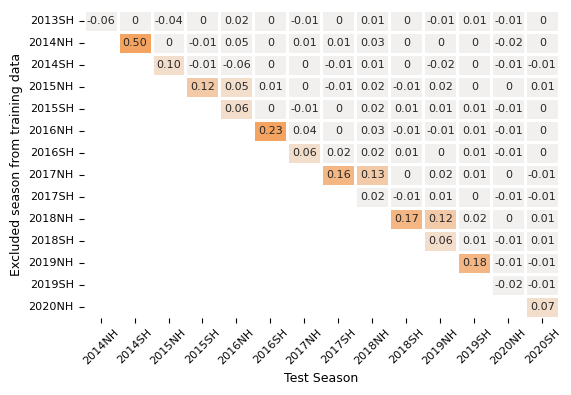

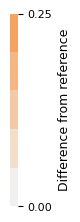

In [13]:
# Reference
fig, ax = plt.subplots(figsize=(6.14,0.25))

tmp = sns.heatmap(df[df.index == 'Reference'],
                  annot=True, annot_kws={"size":8}, fmt='.2f',
                  vmin=0,
                  vmax=0,
                  cmap=ListedColormap(['silver']),
                  cbar=False,
                  linewidths=1,
                  ax=ax)

tmp.tick_params(bottom=False)
tmp.set_xticklabels("")
tmp.set_yticklabels(["Reference"], rotation=0)

ax.set_xlabel("")
ax.set_ylabel("")


fig_fn = path_result + "SuppFig4c_Reference_NoMissedTrainSeason_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')


# missed train season
fig, ax = plt.subplots(figsize=(6.14,4))

fig_cbar, ax_cbar = plt.subplots(figsize=(0.1,2.5))

tmp = sns.heatmap(diff_df[diff_df.index != 'Reference'],
                  mask=mask,
                  annot=True, annot_kws={"size":8}, fmt='.2f',
                  vmin=0.0,
                  vmax=0.25,
                  cmap=sns.light_palette("sandybrown", 5),
                  cbar_ax=ax_cbar,
                  cbar_kws={"shrink":0.85, "orientation":"vertical",
                            "label": "Difference from reference"},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# update the 0.00 and -0.00 text annotations
for text in ax.texts:
    if text.get_text() == '0.00' or text.get_text() == '-0.00':
        text.set_text('0')

tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)

cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(9)
cbar.ax.set_yticks([cbar.ax.get_yticks()[0], cbar.ax.get_yticks()[-1]])
# cbar.ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel("Test Season", fontsize=9)
ax.set_ylabel("Excluded season from training data", fontsize=9)


fig_fn = path_result+"SuppFig4c_miss1TrainSeason_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')


fig_cbar_fn = path_result+"SuppFig4c_miss1TrainSeason_heatmap_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')